**Gravitational Wave Classification using Convolutional Neural Networks (CNNs)**

**Introduction**

Gravitational Waves (GWs) have recently been observed from binary coalescences of condensed objects (black holes, BHs; neutron stars, NSs). The observations are inherently noisy, with many local noise sources. Thus, a coincident detection approach is useful. Currently, three detectors are in operation: LIGO's (Laser Interferometer Gravitational-Wave Observatory) Hanford and Louisiana detectors in the US, and the Virgo detector in Italy. Here, we present data from the two LIGO detectors. Thus, the data can be assembled in the form of two channels, one from each LIGO detector. In addition, the data, in the form of strain (on the order of fractions of an atomic nuclues, i.e., fractions of a femtometer, 1e-15 m) in the 2 km arms of the laser interferometer detectors, is recorded as a function of frequency (39 frequencies) and time (100 time intervals). Thus, the data can naturally be assembled in the form of a tensor object of size (data_measurments, frequencies=39, time_intervals=100, detector_channels=2). For weak signals (i.e. distant or relatively small BH or NS mass objects), it is not obvious if the data indicate an event or just noise. We present here data consisting of 1568 gravitational wave (GW) events and 1216 nondetection (ND) events (total: 2784), a binary classification problem. The data will be randomized and split as 15-15-70% for test, validation, and training.

Why are we so concerned with quickly determining if a potential event is a true GW event? The reason is that some of these events may also produce radiation which quickly fades. Thus, to further advance the understanding of such extreme astrophysical phenomenon, it is essential to quickly identify true positive GWs and point other instruments (e.g., radio, visible, UV, and x-ray telescopes) in the appropriate direction to observe fast events following the BH/NS collisions.

In the initial part of this project, we have followed the approach and use the data of Michel Kana (see https://github.com/michelkana/Deep-learning-projects), as also described in a Medium article (https://medium.com/swlh/gravitational-waves-explained-83ce37617ab2) and a Toward Data Science article (https://towardsdatascience.com/2020-how-a-i-could-help-astronomers-sorting-big-data-811571705707). We both intially implement a CIFAR-10 type of CNN classifier (with dropout). Whereas Kana stops at 60 epochs, we continue to 75. However, this still does not stabilize the validation data curves with epoch (accuracy or loss), and neither does use of a learning rate smaller by a factor of ten. Thus, we extend past Kana's approach and use transfer learning with a VGG-16 base and a trained binary classifier, which is shown to give exceptionally good performance with minimal effort, despite the rather different types of data introduced here compared to what was used to train VGG-16. This again confirms the power of transfer learning and its applicability across diverse fields.  

**Data overview**

In [157]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/dlpython/Project3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from random import seed
from random import randint
import seaborn as sns

seed(30)

GW = np.load('/content/drive/My Drive/dlpython/Project3/data/GW_aug.npy')
ND = np.load('/content/drive/My Drive/dlpython/Project3/data/ND_aug.npy')
GW.shape, ND.shape

((1568, 39, 100, 2), (1216, 39, 100, 2))

In [159]:
def plot_event(event=0, data=GW): 
    fig, ax = plt.subplots(1,2,figsize=(5,5))
    ax[0].imshow(data[event,:,:,0])
    ax[0].set_title('Event {} - H1'.format(event))
    ax[1].imshow(data[event,:,:,1])
    ax[1].set_title('Event {} - L1'.format(event));

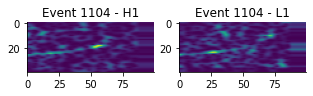

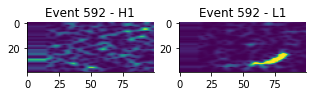

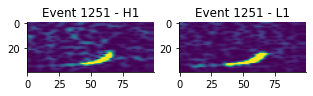

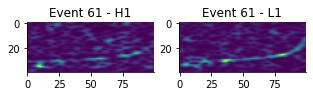

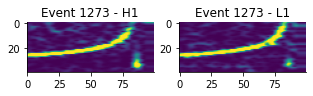

In [160]:
for e in range(5):
    e = randint(0, GW.shape[0])
    plot_event(e)

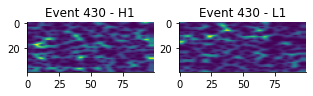

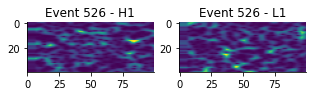

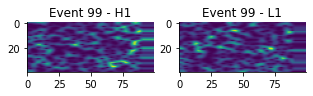

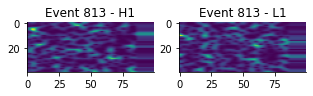

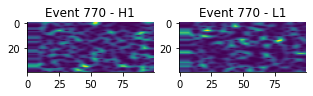

In [161]:
for e in range(5):
    e = randint(0, ND.shape[0])
    plot_event(e, data=ND)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


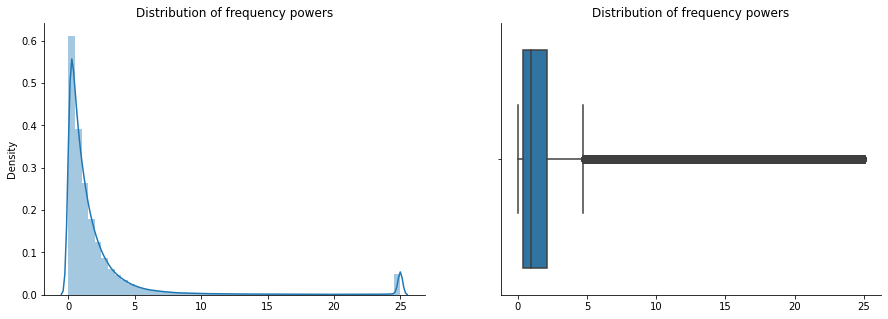

In [162]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(GW.flatten(), ax=ax[0])
ax[0].set_title('Distribution of frequency powers')
sns.boxplot(np.unique(GW), ax=ax[1])
ax[1].set_title('Distribution of frequency powers');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


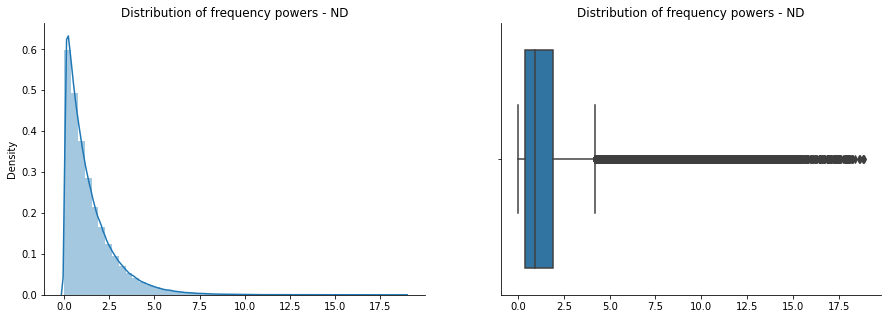

In [163]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(ND.flatten(), ax=ax[0])
ax[0].set_title('Distribution of frequency powers - ND')
sns.boxplot(np.unique(ND), ax=ax[1])
ax[1].set_title('Distribution of frequency powers - ND');

It is seen that the data are broadly similar. There are some outliers in the true GW events.

**Data preprocessing and splitting**

Now we normalize and split the data.

In [164]:
GW = GW.astype('float32')/np.max(GW)
ND = ND.astype('float32')/np.max(ND)

np.random.seed(30)
np.random.shuffle(GW)
np.random.shuffle(ND)

In [165]:
X = np.append(GW, ND, axis=0)
Y = np.append(np.ones((GW.shape[0],1)), np.zeros((ND.shape[0],1)), axis=0)
X.shape, Y.shape, GW.shape, ND.shape

((2784, 39, 100, 2), (2784, 1), (1568, 39, 100, 2), (1216, 39, 100, 2))

In [166]:
test_val_idx = np.random.choice(np.arange(0, Y.shape[0], 1), size=round(.3*Y.shape[0]), replace=False)

In [167]:
test_idx = np.random.choice(test_val_idx, size=round(.5*test_val_idx.shape[0]), replace=False)

In [168]:
val_idx = np.setdiff1d(test_val_idx, test_idx)

In [169]:
train_idx = np.setdiff1d(np.arange(0, Y.shape[0], 1), test_val_idx)

In [170]:
test_idx.shape, val_idx.shape, train_idx.shape

((418,), (417,), (1949,))

In [171]:
test_idx.shape[0]+val_idx.shape[0]+train_idx.shape[0]

2784

In [172]:
np.intersect1d(test_idx, val_idx)

array([], dtype=int64)

In [173]:
np.intersect1d(val_idx, train_idx)

array([], dtype=int64)

In [174]:
np.intersect1d(test_idx, train_idx)

array([], dtype=int64)

In [175]:
print(np.amin(test_idx), np.amax(test_idx)) 

8 2775


In [176]:
print(np.amin(val_idx), np.amax(val_idx)) 

1 2745


In [177]:
print(np.amin(train_idx), np.amax(train_idx))

0 2783


In [178]:
X_test = X[test_idx]
y_test = Y[test_idx]
X_val = X[val_idx]
y_val = Y[val_idx]
X_train = X[train_idx]
y_train = Y[train_idx]

In [179]:
print(X_test.shape, y_test.shape, X_val.shape, y_val.shape, X_train.shape, y_train.shape)

(418, 39, 100, 2) (418, 1) (417, 39, 100, 2) (417, 1) (1949, 39, 100, 2) (1949, 1)


In [180]:
np.unique(y_test), np.unique(y_val), np.unique(y_train)

(array([0., 1.]), array([0., 1.]), array([0., 1.]))

**Methods and Results**

**1. Construct the CNN: First replicate Kana's CIFAR-10 - style CNN**

In [181]:
#  tensorflow library provides functions for deep neural networks 
import tensorflow as tf
# for reproducibility 
from numpy.random import seed
seed(30)
# tf.random.set_seed(30)

#  to get a text report showing the main classification metrics for each class
from sklearn.metrics import classification_report

In [182]:
def create_cnn(input_shape=X_train.shape[1:], nb_classes=1, nb_blocks=3, nb_filters=32, filter_size=(3,3), 
               pool_size=(2,2), weight_decay=1e-4, padding='same', dropout=.2, output_activation='softmax'):

    model = tf.keras.models.Sequential()

    for i in range(nb_blocks):
        if i==0:
            model.add(tf.keras.layers.Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=input_shape))
        else:
            model.add(tf.keras.layers.Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))        
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(nb_filters, filter_size, activation='relu', padding=padding, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size))
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(nb_classes, activation=output_activation))

    return model

In [183]:
model = create_cnn(input_shape=X_train.shape[1:], nb_classes=1, nb_blocks=2, 
                    nb_filters=32, weight_decay=1e-4, padding='same', dropout=.3, output_activation='sigmoid')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 39, 100, 32)       608       
_________________________________________________________________
batch_normalization_12 (Batc (None, 39, 100, 32)       128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 39, 100, 32)       9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 39, 100, 32)       128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 50, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 19, 50, 32)       

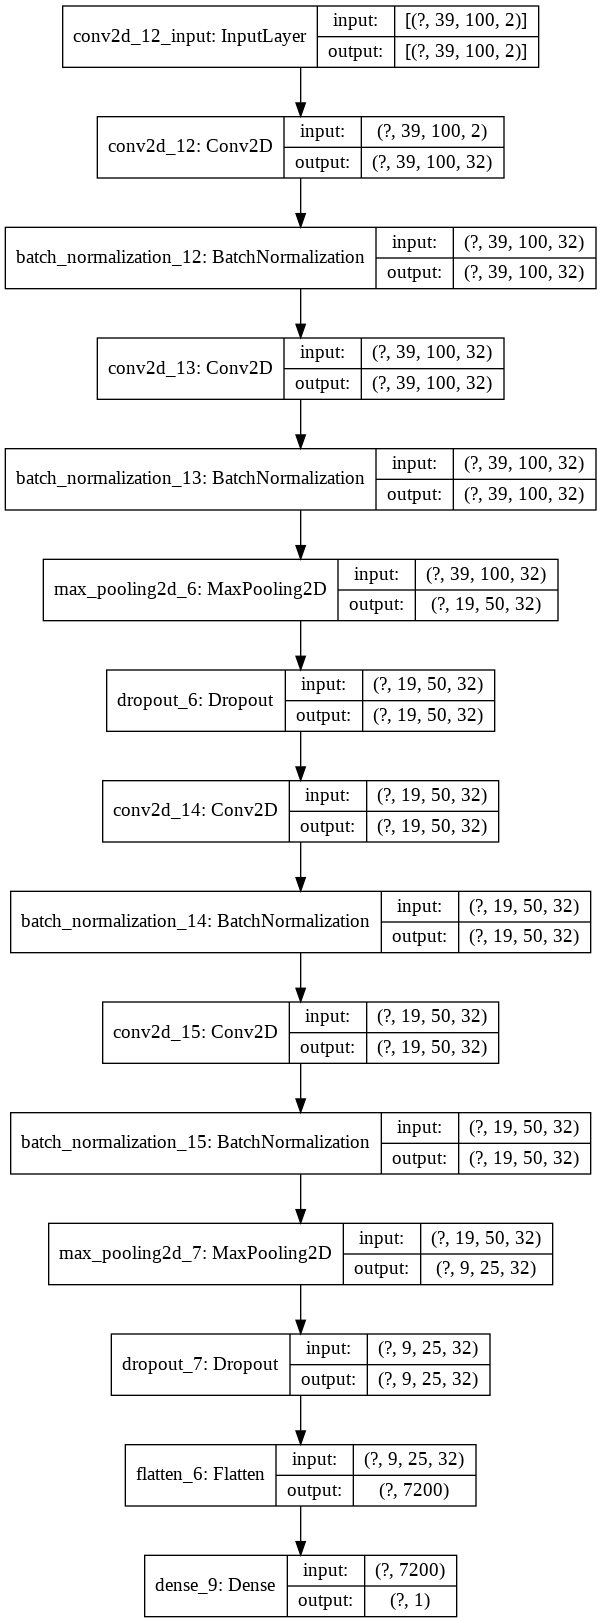

In [184]:
# plot the graph  of the model and save to file
tf.keras.utils.plot_model(
    model,
    to_file='model.png', show_shapes=True, show_layer_names=True)

In [185]:
def plot_history(history):
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import tensorflow
    
    #-----------------------------------------------------------
    # Retrieve results on training and validation data sets
    # for each training epoch
    #-----------------------------------------------------------
    
    # check the current version
    if int(tensorflow.__version__.split('.')[0]) > 1:
        acc_key = 'accuracy'
    else:
        acc_key = 'acc'
        
    acc      = history.history[acc_key]
    val_acc  = history.history['val_' + acc_key]
    loss     = history.history['loss']
    val_loss = history.history['val_loss']
    epochs   = range(1,len(acc)+1) 
    
    plt.rcParams['font.size'] = 16
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    ax1.plot(epochs, acc,  label='Training accuracy')
    ax1.plot(epochs, val_acc,  label='Validation accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.set_ylim(0.5,1.2)
    
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------

    ax2.plot(epochs, loss,  label='Training Loss')
    ax2.plot(epochs, val_loss,  label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.set_ylim(-0.3,3)
    ax2.legend()

    fig.tight_layout()
    plt.show()

In [186]:
opt_rms = tf.keras.optimizers.RMSprop(lr=0.01, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
batch_size = 64
epochs = 75

In [187]:
%%time 

history = model.fit(X_train, y_train, batch_size=batch_size, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X_val, y_val))

Epoch 1/75
31/31 [==============================] - 1s 25ms/step - loss: 0.2546 - accuracy: 0.9215 - val_loss: 0.8524 - val_accuracy: 0.4221
Epoch 2/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0396 - accuracy: 0.9897 - val_loss: 2.0774 - val_accuracy: 0.4221
Epoch 3/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 4.0662 - val_accuracy: 0.4221
Epoch 4/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0164 - accuracy: 0.9969 - val_loss: 7.4341 - val_accuracy: 0.4221
Epoch 5/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 9.0041 - val_accuracy: 0.4221
Epoch 6/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0106 - accuracy: 0.9995 - val_loss: 11.0709 - val_accuracy: 0.4221
Epoch 7/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 10.7740 - val_accuracy: 0.4221
Epoch 8/75


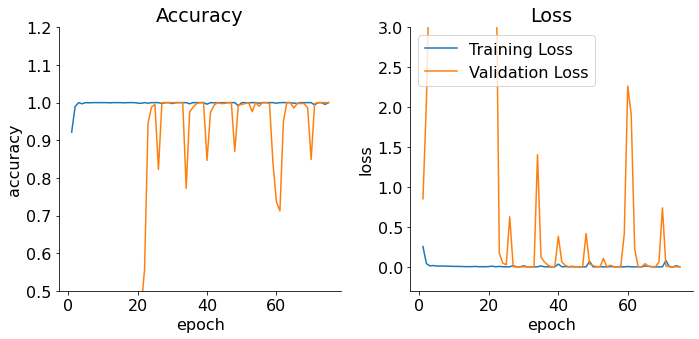

In [188]:
plot_history(history)

In [189]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=2)
print('Accuracy on test dataset:', test_accuracy)

4/4 - 0s - loss: 1.4495e-04 - accuracy: 1.0000
Accuracy on test dataset: 1.0


After 75 epochs the validation curves have not stabilized stabilized. Let's try a smaller learning rate.

**2. Same CNN CIFAR-10 style model, but 10x smaller learning rate**

In [190]:
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
batch_size = 64
epochs = 75

In [191]:
%%time 

history = model.fit(X_train, y_train, batch_size=batch_size, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X_val, y_val))

Epoch 1/75
31/31 [==============================] - 1s 23ms/step - loss: 0.0210 - accuracy: 0.9959 - val_loss: 0.0665 - val_accuracy: 0.9640
Epoch 2/75
31/31 [==============================] - 1s 18ms/step - loss: 5.6628e-04 - accuracy: 1.0000 - val_loss: 8.7125e-04 - val_accuracy: 1.0000
Epoch 3/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0032 - accuracy: 0.9985 - val_loss: 5.1240 - val_accuracy: 0.6307
Epoch 4/75
31/31 [==============================] - 1s 18ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 2.5072 - val_accuracy: 0.7242
Epoch 5/75
31/31 [==============================] - 1s 18ms/step - loss: 2.2802e-04 - accuracy: 1.0000 - val_loss: 0.7324 - val_accuracy: 0.8825
Epoch 6/75
31/31 [==============================] - 1s 18ms/step - loss: 1.2605e-04 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 0.9952
Epoch 7/75
31/31 [==============================] - 1s 18ms/step - loss: 1.0173e-04 - accuracy: 1.0000 - val_loss: 9.2721e-05 - val_accura

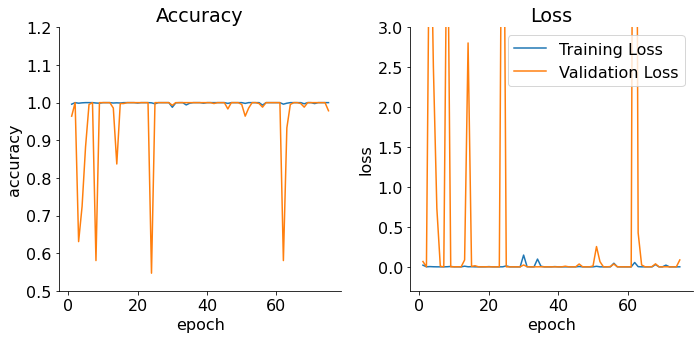

In [192]:
plot_history(history)

In [193]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=2)
print('Accuracy on test dataset:', test_accuracy)

4/4 - 0s - loss: 0.2530 - accuracy: 0.9665
Accuracy on test dataset: 0.9665071964263916


While the training curves above are smooth, the extreme variability in the validation curves and the lack of a convergence gives cause for concern. Evidently, the number of epochs run will randomly detemine the performance on validation and test data. We need a better method.

**3. Transfer earning: VGG-16 (fixed weights) plus a classifier head (trainable weights)**

Since VGG-16 expects a three-channel input, we will place the average of the two channels in the third channel.

In [194]:
print(X_test.shape)
X3_test = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]+1))
X3_test[..., 0] = X_test[..., 0]
X3_test[..., 1] = X_test[..., 1]
X3_test[..., 2] = (X_test[..., 1] + X_test[..., 1]) / 2.0
print(X3_test.shape)

(418, 39, 100, 2)
(418, 39, 100, 3)


In [195]:
print(X_val.shape)
X3_val = np.zeros((X_val.shape[0], X_val.shape[1], X_val.shape[2], X_val.shape[3]+1))
X3_val[..., 0] = X_val[..., 0]
X3_val[..., 1] = X_val[..., 1]
X3_val[..., 2] = (X_val[..., 1] + X_val[..., 1]) / 2.0
print(X3_val.shape)

(417, 39, 100, 2)
(417, 39, 100, 3)


In [196]:
print(X_train.shape)
X3_train = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]+1))
X3_train[..., 0] = X_train[..., 0]
X3_train[..., 1] = X_train[..., 1]
X3_train[..., 2] = (X_train[..., 1] + X_train[..., 1]) / 2.0
print(X3_train.shape)

(1949, 39, 100, 2)
(1949, 39, 100, 3)


**Further preprocessing found to not be necessary.** We thought about trying to preprocess the data in the exact way expected by VGG-16 (subtracting average value from each pixel) and rescaling the image from 39 x 100 to 228 x 228 but this is expected to have minimal effect. We see below that exceptional performance is already obtained without those additional steps.

In [197]:
# load pre-trained model from keras
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(X3_train.shape[1], X3_train.shape[2], 3))

In [198]:
# print summary of convolutional base
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 39, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 39, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 39, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 19, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 19, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 19, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 9, 25, 128)        0     

In [199]:
conv_base.trainable = False

In [200]:
model = tf.keras.models.Sequential()

# add convolutional base as layer 
model.add(conv_base)

model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))

# display model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 3, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               393472    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 15,108,417
Trainable params: 393,729
Non-trainable params: 14,714,688
_________________________________________________________________


In [201]:
opt_rms = tf.keras.optimizers.RMSprop(lr=2e-5, decay=1e-6) # this is much smaller lr than previous lr=0.01
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
batch_size = 64
epochs = 75

In [202]:
%%time 

history = model.fit(X3_train, y_train, batch_size=batch_size, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X3_val, y_val))

Epoch 1/75
31/31 [==============================] - 1s 35ms/step - loss: 0.3992 - accuracy: 0.8250 - val_loss: 0.1879 - val_accuracy: 0.9376
Epoch 2/75
31/31 [==============================] - 1s 30ms/step - loss: 0.2238 - accuracy: 0.9015 - val_loss: 0.1678 - val_accuracy: 0.9353
Epoch 3/75
31/31 [==============================] - 1s 30ms/step - loss: 0.1651 - accuracy: 0.9359 - val_loss: 0.1282 - val_accuracy: 0.9544
Epoch 4/75
31/31 [==============================] - 1s 30ms/step - loss: 0.1478 - accuracy: 0.9456 - val_loss: 0.2664 - val_accuracy: 0.8921
Epoch 5/75
31/31 [==============================] - 1s 30ms/step - loss: 0.1371 - accuracy: 0.9487 - val_loss: 0.0882 - val_accuracy: 0.9784
Epoch 6/75
31/31 [==============================] - 1s 30ms/step - loss: 0.1037 - accuracy: 0.9615 - val_loss: 0.0663 - val_accuracy: 0.9808
Epoch 7/75
31/31 [==============================] - 1s 30ms/step - loss: 0.0914 - accuracy: 0.9702 - val_loss: 0.0908 - val_accuracy: 0.9568
Epoch 8/75
31

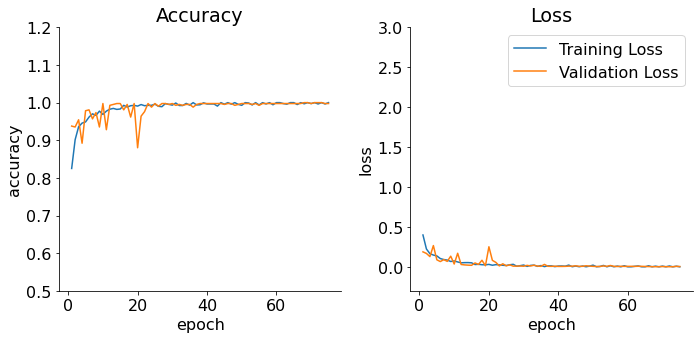

In [203]:
plot_history(history)

In [204]:
test_loss, test_accuracy = model.evaluate(X3_test, y_test, batch_size=128, verbose=2)
print('Accuracy on test dataset:', test_accuracy)

4/4 - 0s - loss: 0.0035 - accuracy: 0.9976
Accuracy on test dataset: 0.9976076483726501


VGG-16 using only training of the classifier head gives exceptional performance. The validation curves are smooth (unlike the case for the CIFAR-10 style fit), which gives confidence in the result. There is no evidence of overfitting. The accuracy on the test data set is 0.993.

**Fine tuning not required since obtained accuracy is sufficient.** The next step would be to try fine tuning, i.e., continuing the preceding fit but releasing also the top layer weights in the VGG-16, and using an even smaller learning rate. However, this is seen to be not necessary.

**Conclusions**

We found that the CIFAR-10 style CNN (with 35,809 trainable parameters,  compared to our training set size of 1,949) did not give trustworthy results with either the larger or smaller learning rate as evidenced by the extreme varibility in the validation accuracy and loss curves. However, a transfer learning approach using the VGG-16 CNN model as the base (Total params: 15,108,417; Trainable params: 393,729) gave exceptionally smooth and good results, with an accuracy on the test data set of 0.998. This again affirms the transfer learning method and its facile and broad applicability across diverse fields.